# 2nd milestone

In [1]:
from keras import models
from keras import layers
from keras import optimizers
from keras.layers import Dense, Activation, BatchNormalization, Conv2D, BatchNormalization, MaxPooling2D, UpSampling2D, Flatten
import numpy as np
import scipy as sp
from skimage import color
import warnings
import keras
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

O:\ProgrammingSoftwares\anaconda3\envs\tensor-cpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Starting info

I started from this paper: <b>Colorful image colorization - Richard Zhang, Phillip Isola, Alexei A. Efros</b>
https://arxiv.org/pdf/1603.08511.pdf

In short they found out, that image colorization problem considered as a multinomial classification problem give better results than the other older solutions for this problem. Because of that, they first turned the RGB pixels into LAB colorspace. In this colorspace, the colorisation problem can be interpreted as input = L, output = a,b.  
First they created an RGB distribution ->  RGB(a,b|L = 50)
![RGB distribution](img_for_description/rgb_distribution.png)  
  
After that they discretize the values, with this method they got 313 class which are different pixels. This discretized list is saved to numpy pts_hull_file, it is a 2 dimensional with shape of (313,2) where the axis 1 refers to a,b pairs.
I'm using up this array, in my function D which map all of the pixel=(L1,a1,b1) to a one hot encoded vector with shape (313,).   This D decide where this pixel belong from the discretized values, after that encode to one hot vector.


https://en.wikipedia.org/wiki/CIELAB_color_space  
  
### Comments for the below code

    - Image folder is where all of you data is, you have to change to your filepath, where is your samples.

    - Pts_hull_file is the discrete class array, which are created from RGB-LAB distribution. You don't have to recreate, it is in the repo/samples folder.
    
    - ImageLoader class will hold the prepared data for the training and evaluation.
    - img_loader.separate_small_data(valid_split,test_split) prepares the data to train.


In [10]:
# Import own .py files
import data_collector
import image_loader
import nnetwork
from importlib import reload  # Python 3.4+ only.
image_loader = reload(image_loader)
import gc


def teszt():
    gc.collect()
    image_folder = 'O:/ProgrammingSoftwares/anaconda_projects/dp_nagyhazi/samples/images/'
    pts_hull_file = 'O:/ProgrammingSoftwares/anaconda_projects/dp_nagyhazi/samples/pts_in_hull.npy'

    img_loader = image_loader.ImageLoader(image_folder, pt_in_hull_folder = pts_hull_file)

    # Separate_small_data(validation_rate, test_rate)
    img_loader.separate_small_data(0.1,0.1)
    return img_loader

In [11]:
#%load_ext memory_profiler
img_loader = teszt()

Length of image list:  24


O:\ProgrammingSoftwares\anaconda3\envs\tensor-cpu\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Gigabyte of dataset:  0.02691650390625
Gigabyte of y_dataset:  0.001682281494140625


### Info for the below code.

I've created the first model, which built up from a vgg16 keras model and after it batch norm and some convolution layers. These last convolution layers are responsible to convert the collected features into an a,b discretized distribution. Becuase of multinomial classification i thought the categorical crossentropy will be the best for me.

In [4]:
model = nnetwork.create_vgg_model()
model.compile('adam', loss = 'categorical_crossentropy',
              metrics=['accuracy', keras.metrics.categorical_accuracy])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 56, 56, 512)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 313)       1442617   
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 313)       98282     
Total params: 16,255,587
Trainable params: 3,900,707
Non-trainable params: 12,354,880
_________________________________________________________________


In [5]:
patience=1
early_stopping=EarlyStopping(patience=patience, verbose=1)
checkpointer=ModelCheckpoint(filepath='weights.hdf5', save_best_only=True, verbose=1)

In [6]:
history = model.fit(x=img_loader.X_train,
                    y=img_loader.Y_train,
                    batch_size=16,
                    epochs=10,
                    validation_data=(img_loader.X_valid,img_loader.Y_valid),
                   callbacks=[checkpointer, early_stopping])

Train on 19 samples, validate on 2 samples
Epoch 1/10
19/19 [==============================] - 20s 1s/step - loss: 5.5523 - acc: 0.0478 - categorical_accuracy: 0.0478 - val_loss: 2.5301 - val_acc: 0.3133 - val_categorical_accuracy: 0.3133

Epoch 00001: val_loss improved from inf to 2.53009, saving model to weights.hdf5
Epoch 2/10
19/19 [==============================] - 20s 1s/step - loss: 3.4288 - acc: 0.3280 - categorical_accuracy: 0.3280 - val_loss: 2.9386 - val_acc: 0.1545 - val_categorical_accuracy: 0.1545

Epoch 00002: val_loss did not improve from 2.53009
Epoch 00002: early stopping


In [7]:
score = model.evaluate(img_loader.X_test, img_loader.Y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

3/3 [==============================] - 2s 591ms/step
Test loss: 3.7909908294677734
Test accuracy: 0.08801020681858063


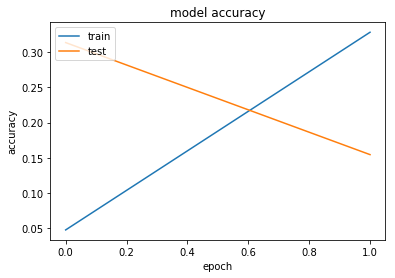

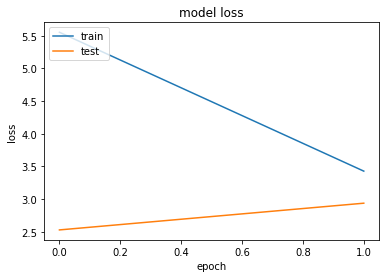

In [13]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Changing the <b>idx</b> you can try out what did the network do.

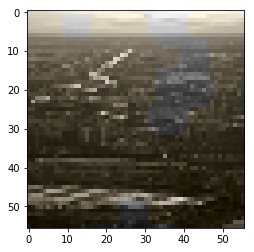

In [12]:
from matplotlib.pyplot import imshow
from skimage import color
import matplotlib.pyplot as plt
%matplotlib inline

idx = 4

y_real = model.predict(img_loader.X_train[idx].reshape((1,224,224,3)))
y_real = np.apply_along_axis(lambda x: img_loader.pts_in_hull[np.argmax(x)], axis=3, arr = y_real)
img_loader.pts_in_hull # létező színosztályok

lab_im = np.concatenate([img_loader.y_dataset[np.newaxis,idx,:,:,0, np.newaxis],y_real ], axis=3)
rgb_im = color.lab2rgb(lab_im[0])
plt.imshow(rgb_im)